In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(420)

In [3]:
data = pd.read_csv("data/weather_data.csv").applymap(lambda x: x.lower())
data.columns = data.columns.str.lower()

In [4]:
data.head()

,outlook,temperature,humidity,wind,play
0,sunny,hot,high,weak,no
1,sunny,hot,high,strong,no
2,overcast,hot,high,weak,yes
3,rain,cool,normal,weak,yes
4,rain,cool,normal,strong,no


In [5]:
X,y = data.iloc[:,:-1], data.iloc[:,-1]

# Decision Tree ID3 Algorithm

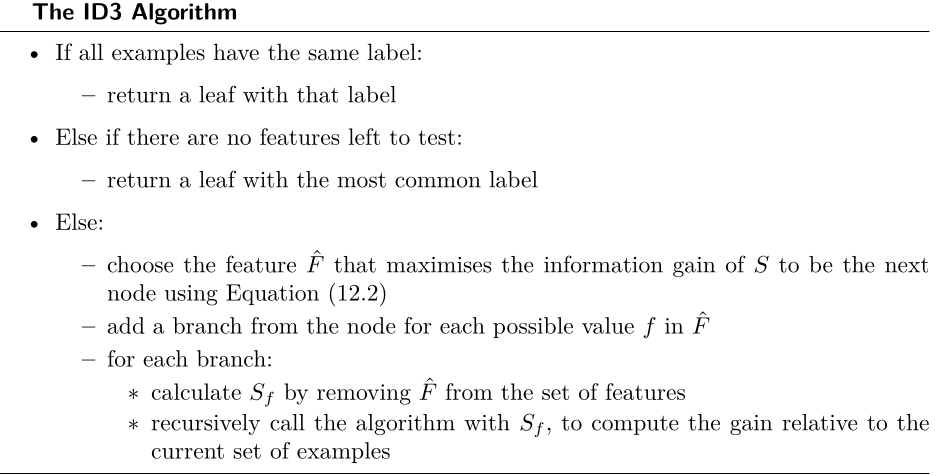

Information gain,
$$
Gain(S,F) = Entropy(S) - \sum_{f \in values(F)} \frac {|S_f|} {|S|} Entropy(S_f).
$$
and the entropy function,
$$
Entropy(p) = −
\sum_i p_i \log_2 p_i ,
$$

In [6]:
def entropy(C_counts):
    ent = 0
    C_tot = sum(C_counts)
    for C_i in C_counts:
        p = C_i/C_tot
        ent += p*np.log2(p)
    return -ent

In [7]:
def information_gain(X,y,F,N):
    N = len(X)
    values = X[F].unique() # f \in Values(F)
    gain = 0
    
    for f in values:
        S_f = X[X[F] == f]
        M = len(S_f)
        C_counts = y[S_f.index].value_counts().to_list()
        gain += M/N * entropy(C_counts)
    return gain

In [8]:
def ID3(X,y,random = False):
    Features = X.columns.to_list()
    N = len(X)
    C_dict = y.value_counts().to_dict()
    C, C_counts = list(C_dict.keys()),list(C_dict.values())
    if not random: total_entropy = entropy(C_counts)
    
    if len(C) == 1: return C[0]
    elif len(Features) == 0: return C[np.argmax(C_counts)]
    else:
        if random: F_cap = np.random.choice(Features)
        else:
            info_gain_F = [total_entropy - information_gain(X,y,F,N) for F in Features]
            F_cap = Features[np.argmax(info_gain_F)] # the best feature
        
        tree = {F_cap: dict()}
        values = X[F_cap].unique()
        
        F_cap_removed = X.drop(F_cap,axis=1)
        for f in values:
            X_f = F_cap_removed[X[F_cap] == f]
            y_f = y[X_f.index] 
            
            tree[F_cap][f] = ID3(X_f,y_f)
    
    return tree    

In [9]:
def pretty_print_tree(tree, indent=0):
    if isinstance(tree,str): 
        print(' '*indent,tree)
        return
    for key, value in tree.items():
        print(' ' * indent, end='')
        if isinstance(value, dict):
            print(key)
            pretty_print_tree(value, indent + 2)
        else:
            print(f'{key}: {value}')
            

In [10]:
dtree = ID3(X,y)

In [11]:
pretty_print_tree(dtree)

outlook
  sunny
    humidity
      high: no
      normal: yes
  overcast: yes
  rain
    wind
      weak: yes
      strong: no


In [12]:
def make_decision(X,dtree):
    if not isinstance(dtree,dict): return dtree
    for key,values in dtree.items():
        nxt = X[key]
        if nxt not in values: continue
        decision = make_decision(X, values[nxt])
        if decision: return decision
    return None

In [13]:
new_sample = ["sunny","hot","normal","weak"]
sample = {f:new_sample[i] for i,f in enumerate(X.columns)}

In [14]:
make_decision(sample,dtree)

'yes'

# Random Forest
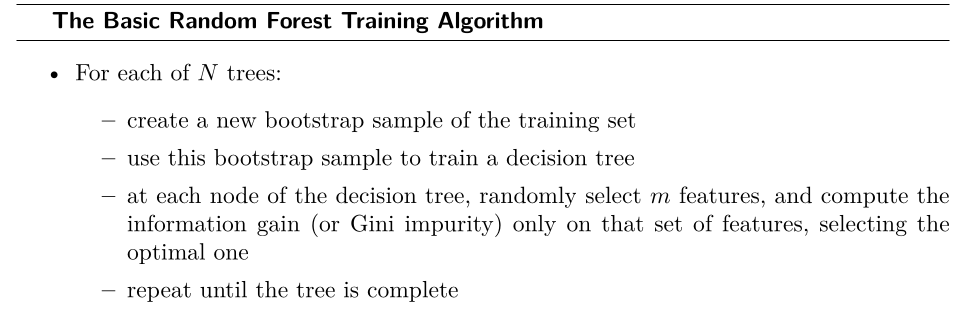

In [15]:
def boostrap_sample(X,y,n):
    idx = np.random.choice(X.index,n,replace=True)
    return X.loc[idx], y.loc[idx]

In [16]:
def random_forest(X,y,N,sample_size=10):
    forest = [None]*N
    
    for i in range(N):
        sample_x,sample_y = boostrap_sample(X,y,sample_size)
        forest[i] = ID3(sample_x,sample_y,True)
    return forest

In [17]:
Forest = random_forest(X,y,17,21)

In [18]:
def make_decision_forest(X,Forest):
    decisions = [make_decision(X,dtree) for dtree in Forest]
    count = {}
    for d in decisions:
        if d not in count: count[d] = 0
        count[d] +=1
    print(count)
    return max(count,key =count.get)

In [19]:
for dtree in Forest:
    pretty_print_tree(dtree)
    print("~"*20)

wind
  strong
    temperature
      hot: no
      mild: yes
      cool: no
  weak
    humidity
      normal: yes
      high
        outlook
          sunny: no
          rain: yes
~~~~~~~~~~~~~~~~~~~~
temperature
  cool
    outlook
      overcast: yes
      sunny: yes
      rain: no
  mild
    outlook
      sunny
        humidity
          normal: yes
          high: no
      rain
        wind
          strong: no
          weak: yes
      overcast: yes
  hot: yes
~~~~~~~~~~~~~~~~~~~~
humidity
  normal
    wind
      weak: yes
      strong
        outlook
          rain: no
          overcast: yes
  high
    outlook
      overcast: yes
      sunny: no
      rain
        wind
          weak: yes
          strong: no
~~~~~~~~~~~~~~~~~~~~
wind
  weak
    temperature
      mild: yes
      cool: yes
      hot
        outlook
          overcast: yes
          sunny: no
  strong
    outlook
      overcast: yes
      sunny: yes
      rain: no
~~~~~~~~~~~~~~~~~~~~
outlook
  sunny
    humidity
 

In [20]:
new_sample = ["sunny","cool","normal","weak"]
sample = {f:new_sample[i] for i,f in enumerate(X.columns)}

In [21]:
make_decision_forest(sample,Forest)

{'yes': 15, 'no': 2}


'yes'